# Convert ASCII Grid File to Cloud Optimised GeoTIFF

Downloads a zipped ASCII grid elevation file and exports it as a COG.

The zip file contains:
1. The raster data (.asc file)
2. The data's projection (.prj file)
3. A metadata html file (which we'll ignore)

### Load packages

In [1]:
import io
import os
import pathlib
import rasterio.crs
import rasterio.plot
import requests
import zipfile

from matplotlib import pyplot
from rasterio.io import MemoryFile
from rio_cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles

### Settings

In [2]:
# the URL of the elevation data to download
url = "https://portal.spatial.nsw.gov.au/download/dem/56/Sydney-DEM-AHD_56_5m.zip"

# the paths to save the images
output_path = "./data"
download_path = os.path.join(output_path, "downloaded")
converted_path = os.path.join(output_path, "converted")

# create required image directories
pathlib.Path(download_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(converted_path).mkdir(exist_ok=True)

### Download file

...and extract its contents into a list of in-memory files

In [3]:
%%time
# download zipfile
response = requests.get(url)         

CPU times: user 544 ms, sys: 281 ms, total: 824 ms
Wall time: 4.32 s


In [4]:
%%time
# extract each file & add to list of (filename, file-like object) pairs
file_list = list()
with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
    for zipinfo in thezip.infolist():
        with thezip.open(zipinfo) as thefile:
            file_list.append((zipinfo.filename, thefile.read()))   

CPU times: user 2.8 s, sys: 254 ms, total: 3.06 s
Wall time: 3.07 s


### Load raster file & get it's coordinate system

Also, save files to disk for testing (not required for conversion to COG)

Data file size: 790mb

In [5]:
%%time
image = None
crs = None
input_file_name = None
output_file_name = None

for file in file_list:
    file_name = file[0]
    file_obj = file[1]

    # get data as an in-memory file.
    if file_name.endswith(".asc"):
        image = MemoryFile(file_obj)
        input_file_name = file_name
        output_file_name = file_name.replace(".asc", ".tif")

    # get well known text coordinate system from projection file
    if file_name.endswith(".prj"):
        proj_string = file_obj.decode("utf-8")
        crs = rasterio.crs.CRS.from_wkt(proj_string)

    # save each file to disk
    with open(os.path.join(download_path, file_name), "wb") as f:
        f.write(file_obj)

CPU times: user 18.5 ms, sys: 211 ms, total: 229 ms
Wall time: 1.19 s


### Convert to COG

Take the data file & it's coordinate system and convert to a cloud optimised geotiff (COG)

This takes ~13 seconds on a 2017 Mac

COG file size: 240mb

In [6]:
%%time
with image.open() as dataset:
    # create COG profile and set the image compression type & coordinate system
    dst_profile = cog_profiles.get("deflate")
    dst_profile.update({"crs": str(crs)})

    # convert the raster dataset
    with MemoryFile() as output_image:
        cog_translate(dataset, output_image.name, dst_profile, in_memory=True, nodata=-9999)

        # save the COG to disk
        with open(os.path.join(converted_path, output_file_name), "wb") as f:
            f.write(output_image.read())

Reading input: <open DatasetReader name='/vsimem/37b5ab04-f37e-4762-8c7f-a0286b133dc1/37b5ab04-f37e-4762-8c7f-a0286b133dc1.tif' mode='r'>
Adding overviews...
Updating dataset tags...
Writing output to: /vsimem/899097cd-cd4a-4aa7-9c9c-2a847cfa8bce/899097cd-cd4a-4aa7-9c9c-2a847cfa8bce.tif


CPU times: user 16.3 s, sys: 988 ms, total: 17.3 s
Wall time: 18.5 s


### Open & display the COG file

To confirm a successful conversion

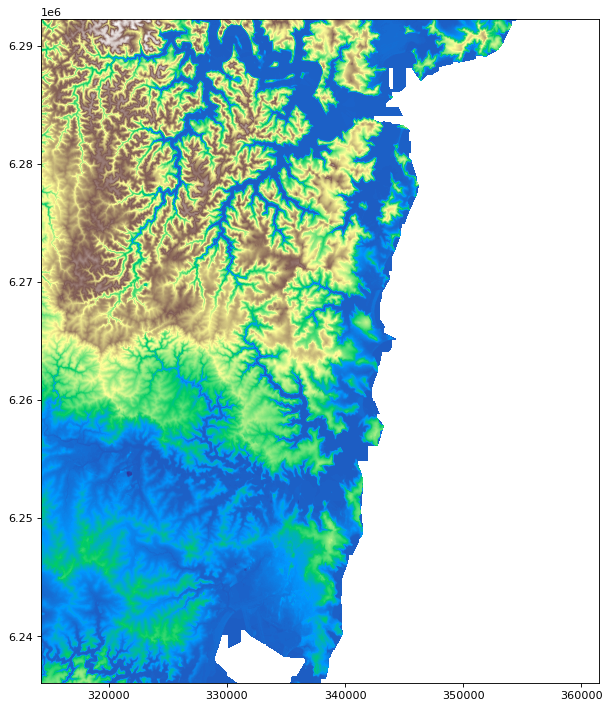

CPU times: user 6.61 s, sys: 1.71 s, total: 8.32 s
Wall time: 8.83 s


In [7]:
%%time
with rasterio.open(os.path.join(converted_path, output_file_name)) as dataset:
    fig = pyplot.figure(figsize=(9, 12), dpi=80)
    rasterio.plot.show(dataset, cmap="terrain")